# Rapport Projet BOMR

Authors

Valentin Suppa-Gallezot   
Mehdi El Bouari   
Thibault Golaz  
Louis Marchand  


## 0. Introduction

### 0.0. Guidlines

For this project we had to construct and implement a mobile robot able to perform path finding method and movement based on vision-oriented programs. The robot we are using here is a Thymio-II robot.
  
The code will follow these guidelines:   
  
•	**Create an environnment:** Our environnement is made of the thymio detectable thank to 2 green circles, obstacles (represented as black sheets of paper), a target represented by a red square of paper and 3d obstacles used to test local navigation (detected by the thymio sensors).  
•	**Find the best path:** The objective is that the Thymio goes its initial position in the map to a target in the environement.  
•	**Motion control:** To control the robot we use functions to correct the angle and close the position to the next goal that is updated upon reach.  
•   **Kalman filter:** In the case where we don't have data from the camera we use, we apply a Kalman filter knowing the last detected/predicted position and the speed given by the robot to compute the next position.  
•	**Local navigation:** While moving, the Thymio has to use local navigation to avoid physical obstacles that can be put in its path at any point in time.  


### 0.1. General overview of the code

<img src="pictures/Diagram.png" width=700/>

## 1. Vision

### 1.0 Most important function in Vision

| Function of Vision | Input | Output |
|:------|:------|:------|
|`detect_start(image, show=False, begin = True)` |receive a frame when the program starts, show allows to plot the image and begin allows to get only the start_coordinates|An image with a white rectangle on the two circles of the thymio and the start coordinates|
|`detect_target(image)`|receive a frame when the program starts|An image with a white rectangle on the target and the coordinates of the target|
|`detect_obstacle(image)`|receive an image with white rectangle on the start and the target|corner coordinates of each obstacle|

### 1.1. Start and target Detection 

In order to obtain the starting point and the target point, we used two colored circles (1 blue and 1 green) of different sizes. These two circles are placed on the robot. At the beginning of the program, a picture of the scene is taken. Using the library opencv and more precisely the function template matching the center of the two circles are detected. Then by just computing the middle of these centers the center of the thymio (called starting point in the program is detected). Two circles are needed because in the following of the code it will allow to compute the orientation of the thymio  
The same method is used to get the target but a red rectangle is used instead.

In [4]:
### code refer

Since the starting point and the goal are detected it is time to compute the coordinates of the obstacle on the map. In our project the obstacles are black 2 dimensions shapes. They are positionned randomly on the field. In order to detect them the image is converted in black and white. To avoid some risk of confusion with the shapes on the thymio and the one for the target, white rectangles are drawn on them. Then, after applying the threshold, the obstacle are detected (#plot image). By using an opencv function, the coordinates of the contours are found. Finaylly by following the steps of this link https://stackoverflow.com/questions/50984205/how-to-find-corners-points-of-a-shape-in-an-image-in-opencv every corner coordinates of each shape are stored in a array. It will be helpful to compute the visibility graph.  

## Global Navigation 

### 2.0. Main functions 

This part of the code is the second step of our code, its goal is to compute the shortest path from the starting position of the thymio to the target while avoiding obstacles. All the elements used in this part are given by the vision part of the code they are transmitted as points.

| Function of Global Navigation | Input | Output |
|:------|:------|:------|
|`build_vis_graph(shapes, start, target)` |Takes a list of points representing the contours of the obstacles and two points standing for the starting and finishing goal of the path. The path is made using pyVisgraph library and avoid obstacle using a visibility graph and a djisktra algorithm |The shortest path in the form of a list of points and the shapes representing the obstacles (also represented as points|


<u>Links of interest:</u>  
    - PyVisgraph library: https://github.com/TaipanRex/pyvisgraph  
    - D.T. Lee : https://taipanrex.github.io/2016/10/19/Distance-Tables-Part-2-Lees-Visibility-Graph-Algorithm.html  

### 2.1. PyVisgraph library 

Given a set of simple obstacle polygons, build a visibility graph and find the shortest path between two points.
Pyvisgraph is a MIT-licensed Python package for building visibility graphs from a list of simple obstacle polygons. The visibility graph algorithm (D.T. Lee) runs in O(n^2 log n) time. The shortest path is found using Djikstra's algorithm.

##  Motion Control

### Astolfi Controller

For the motion controller of the thymio, we opted for an Astolfi controller, which takes as input the coordinates of the thymio, its orientation, and the coordinates of the target location.
It then computes the following coordinates :
- $\rho$ : the distance from the thymio to the goal.
- $\alpha$ : the angle between the straight direction from the thymio to the goal, and the direction along thymio's orientation.
- $\beta$ : the orientation of the vector leading from the thymio to the goal.

These three coordinates can be seen in the image below:

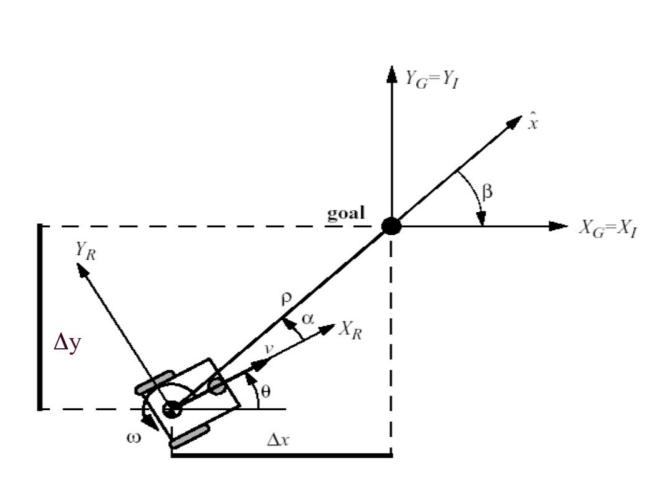

and they can be computed with the following relationships :

\begin{cases}  
\rho= \sqrt{\Delta x^2 + \Delta y^2} \\
\alpha = - \theta + atan2(\Delta y, \Delta x)  \\
\beta = - \theta - \alpha
\end{cases} 

where :
- $\Delta$x : the distance on the x axis from the thymio to the goal.
- $\Delta$y : the distance on the y axis from the thymio to the goal.
- $\theta$ : orientation of the thymio.

It can be shown that the control law : $v=k_\rho \times \rho$ and $\omega=k_\beta \times \beta + k_\alpha \times \alpha$ yields a closed loop system with a unique equilibrium point at $(\rho,\alpha,\beta)=(0,0,0)$, which are the coordinates we want to reach, and that this system is exponentially stable if: $k_\rho>0$, $k_\beta<0$, and $k_\alpha-k_\rho>0$. this set of equation had to be slighlty modified to take into account the flipped y-axis when working directly with pixels.

In our implementation of the Astolfi controller, we chose the coefficient $k_\beta$ to be as close to zero as possible, since this coefficient only affects the orientation of the thymio when it reaches its destination, which doesn't matter in the scope of our project. we also established a distance threshold so the thymio detects when it reaches its destination, and an angle threshold to avoid too much "zig-zagging". Lastly, since the speed is directly proportional to $\rho$, we had to establish and upper and lower limit to the speed in order to avoid speeds that are either too high or too low.

In [ ]:
'''controller constants to tune accordingly'''
kp = 0.5  # >0
ka = 25  # > kp
kb = -0.01  # <0

'''speed limits and sensors thresholds to tune accordingly'''
v_max = 200
v_min = 20
thres_arrived = 50
angle_thres = 0.17
obstSpeedGain = np.array([6,4,-2,-6,-8])/100

'''Controller function'''
def astolfi(pos, theta, target, node, client):
    state = 0  # this functions is called recursivly untill state=1 i.e. the thymio has arrived
    delta_pos = [target[0] - pos[0], -(target[1] - pos[1])]
    rho = np.linalg.norm(delta_pos)
    alpha = -theta - np.arctan2(delta_pos[1], delta_pos[0])
    if alpha>np.pi:
        alpha-=2*np.pi
    elif alpha<-np.pi:
        alpha+=2*np.pi
    beta = theta - alpha
    if beta>np.pi:
        beta-=2*np.pi
    elif beta<-np.pi:
        beta+=2*np.pi
    sensors= np.array(get_prox_sensors(node, client)[0:5])
    vit_obst_left=np.sum(np.multiply(sensors,obstSpeedGain))
    vit_obst_right=np.sum(np.multiply(sensors,np.flip(obstSpeedGain)))
    #print("teta=",theta,"  alpa=",alpha,"  beta=",beta,"  rho=",rho) #prints to debug
    
    if (alpha>angle_thres):
        omega = ka * alpha + kb * beta
    else: 
        omega=kb*beta
    
    omega = ka * alpha + kb * beta
    if rho > thres_arrived:
        v = kp * rho
        if v > v_max: v = v_max
        if v < v_min: v = v_min
    else:
        v = 0
        state = 1
    left_speed = v - omega + vit_obst_left
    right_speed = v + omega + vit_obst_right
    set_motor_speed(int(right_speed), int(left_speed), node)
    return state

### Auxiliary control functions


We also created some auxiliary motion control functions to help control the thymio, which will be quickly described in the following section:

## Local obstacle avoidance

The local obstacle avoidance was directly implemented in the thymios's controller by means of potential fields.
In the "astolfi" function displayed in the previous section,

## Filtering

## Conclusion